# EfficientDet-based Traffic Sign Classification on GTSRB

In [115]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time 

In [90]:
# Parameters
image_size = 64
batch_size = 16
epochs = 5
learning_rate = 0.001
num_classes = 43

In [91]:
# Define label for each class (you already provided this dictionary)
classes = { 0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 
            9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
            12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
            25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
            29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
            32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 35:'Ahead only', 
            36:'Go straight or right', 37:'Go straight or left', 38:'Keep right', 39:'Keep left', 
            40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons' }


In [92]:
# Data generator class to load images in batches
class DataGenerator(Sequence):
    def __init__(self, data_dir, subset, batch_size, image_size, num_classes):
        self.data_dir = data_dir
        self.subset = subset
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        if subset == 'train':
            self.data = [(os.path.join(data_dir, 'Train', label, img), int(label))
                         for label in os.listdir(os.path.join(data_dir, 'Train'))
                         for img in os.listdir(os.path.join(data_dir, 'Train', label))]
        elif subset == 'test':
            self.data = []
            with open(os.path.join(data_dir, 'Test.csv'), 'r') as f:
                lines = f.readlines()[1:]  # Skip header
                for line in lines:
                    fields = line.strip().split(',')
                    self.data.append((os.path.join(data_dir, fields[7]), int(fields[6])))
        self.on_epoch_end()

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for path, label in batch_data:
            image = cv2.imread(path)
            if image is not None:
                image = cv2.resize(image, (self.image_size, self.image_size))
                image = image.astype('float32') / 255.0
                images.append(image)
                labels.append(label)
        images = np.array(images)
        labels = to_categorical(labels, self.num_classes)
        return images, labels

    def on_epoch_end(self):
        np.random.shuffle(self.data)

In [93]:
# Build model
def build_small_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [122]:
# Function to display a prediction
def display_prediction(image, model, classes, ax=None):
    """
    Displays a single image with its predicted label, probability, and true label.
    """
    # Make the prediction
    pred_probs = model.predict(image[np.newaxis, ...])  # Add batch dimension
    pred_label = np.argmax(pred_probs)  # Predicted label
    pred_prob = np.max(pred_probs)  # Highest probability

    # If axis is provided, plot the image on it; otherwise, use plt.imshow
    if ax:
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        ax.set_title(
            f"Predicted: {classes[pred_label]}\n"
            f"Probability: {pred_prob:.4f}"
        )
        ax.axis("off")
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {classes[pred_label]}\nProbability: {pred_prob:.4f}")
        plt.axis("off")
        plt.show()

# Function to visualize predictions
def visualize_predictions(model, test_gen, classes, num_images=10):
    """
    Visualizes predictions for a few samples from the test generator.

    Args:
    - model: Trained Keras model.
    - test_gen: Data generator for testing.
    - classes: List of class names corresponding to labels.
    - num_images: Number of predictions to visualize.
    """
    plt.figure(figsize=(12, 6))

    # Randomly sample `num_images` indices from the test generator
    samples = random.sample(range(len(test_gen)), num_images)

    for i, idx in enumerate(samples):
        # Get a batch of images and labels from the test generator
        image_batch, true_labels_batch = test_gen[idx]
        
        # Select the first image and its true label
        image = image_batch[0]
        true_label = true_labels_batch[0]
        
        # Display the prediction
        ax = plt.subplot(2, 5, i + 1)  # Create a subplot in a 2x5 grid
        display_prediction(image, model, classes, ax)

    plt.tight_layout()
    plt.show()

In [95]:
# Main program
data_dir = '../Dataset'  # Path to your dataset
print("Preparing data generators...")

train_gen = DataGenerator(data_dir, 'train', batch_size, image_size, num_classes)
test_gen = DataGenerator(data_dir, 'test', batch_size, image_size, num_classes)

Preparing data generators...


In [96]:
# Build model
model = build_small_model((image_size, image_size, 3), num_classes)

In [97]:
# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
# Train model
print("Training model...")
start_train_time = time.time()  # Start tracking time for training
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=test_gen,  # Include validation data here
                    verbose=1)
end_train_time = time.time()  # End tracking time for training
train_time = end_train_time - start_train_time  # Calculate total training time

Training model...
Epoch 1/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 99s 40ms/step - accuracy: 0.4378 - loss: 2.0331 - val_accuracy: 0.8855 - val_loss: 0.4466
Epoch 2/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.8404 - loss: 0.5044 - val_accuracy: 0.9236 - val_loss: 0.2887
Epoch 3/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 98s 40ms/step - accuracy: 0.8952 - loss: 0.3219 - val_accuracy: 0.9407 - val_loss: 0.2378
Epoch 4/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.9204 - loss: 0.2447 - val_accuracy: 0.9427 - val_loss: 0.2263
Epoch 5/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 95s 39ms/step - accuracy: 0.9363 - loss: 0.1906 - val_accuracy: 0.9382 - val_loss: 0.2186


In [99]:
# Evaluate model on test data
print("Evaluating model on test data...")
start_test_time = time.time()  # Start tracking time for evaluation
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
end_test_time = time.time()  # End tracking time for evaluation
test_time = end_test_time - start_test_time  # Calculate total test time

Evaluating model on test data...
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9388 - loss: 0.2241


In [100]:
# Print times
print(f"Training Time: {train_time:.15f} seconds")
print(f"Test Time: {test_time:.15f} seconds")
print(f"Test Accuracy: {test_accuracy:.15f}")
print(f"Test Loss: {test_loss:.15f}")

Training Time: 480.647898674011230 seconds
Test Time: 9.892326831817627 seconds
Test Accuracy: 0.938212931156158
Test Loss: 0.218565002083778


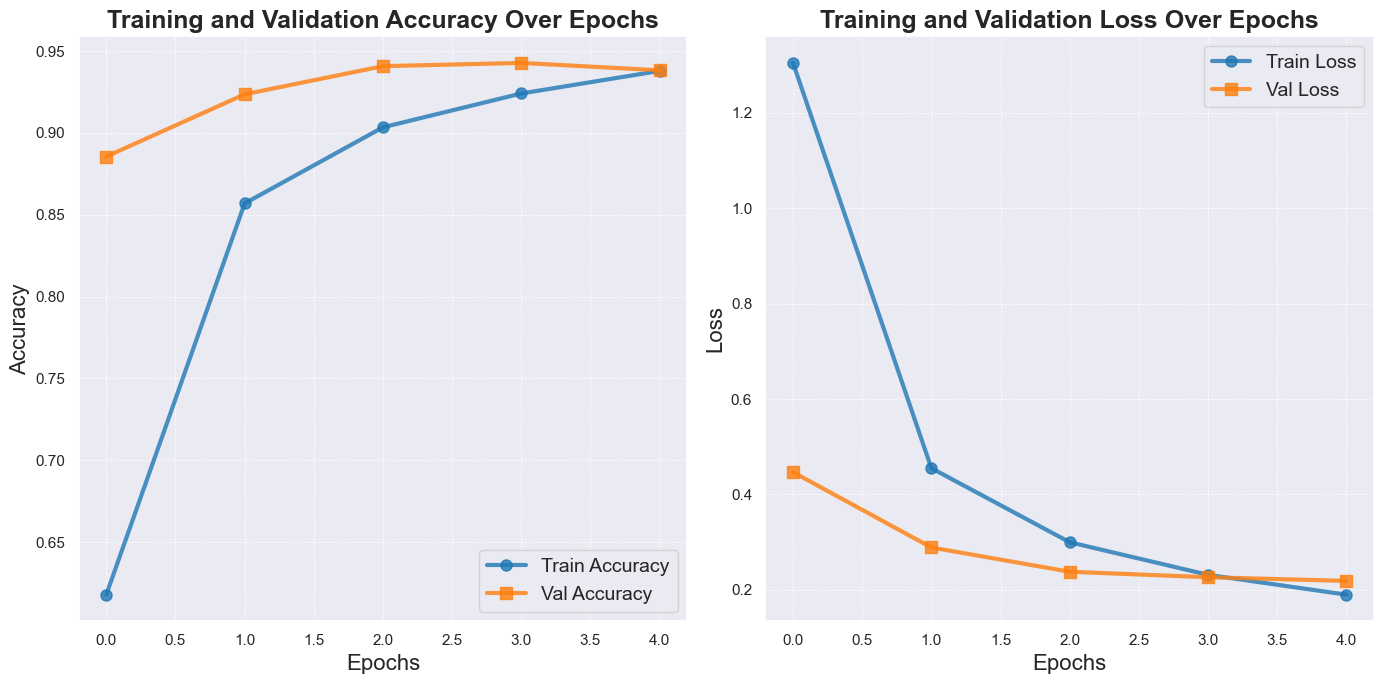

In [101]:
# Plot training and validation history with enhanced colors
import seaborn as sns
sns.set(style="darkgrid")

plt.figure(figsize=(14, 7))

# Accuracy plot with both training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linewidth=3, marker='o', markersize=8, linestyle='-', alpha=0.8)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#ff7f0e', linewidth=3, marker='s', markersize=8, linestyle='-', alpha=0.8)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Loss plot with both training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=3, marker='o', markersize=8, linestyle='-', alpha=0.8)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=3, marker='s', markersize=8, linestyle='-', alpha=0.8)
plt.title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


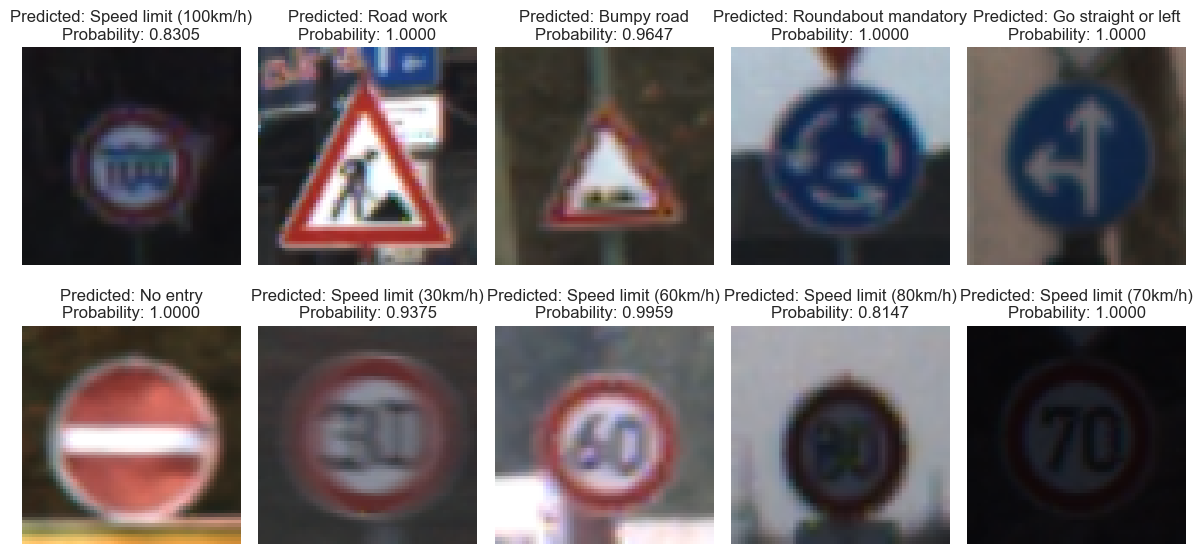

In [123]:

# Call the visualization function
visualize_predictions(model, test_gen, classes, num_images=10)